# Appendix B: code implementation

In [301]:
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


/Users/aksholokhov/.anaconda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['beta', 'gamma', 'grid']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [302]:
from scipy.integrate import solve_ivp
from tqdm import tqdm 
import tensorflow as tf
from keras.models import Sequential 
from keras.layers import Dense, Activation, Conv1D, Flatten, Input, MaxPool1D, Concatenate
from mpl_toolkits.mplot3d import Axes3D
import pickle
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from keras.models import Model
from datetime import datetime
from ipypb import track

# 1. Lorenz oscillator 

In [303]:
dt = 0.01
T = 20
t = arange(0, T, dt)
b = 8/3; sig=10; r=28;
lorenz = lambda t, x: [sig*(x[1] - x[0]), r*x[0] - x[0]*x[2] - x[1], x[0]*x[1] - b*x[2]]
x0 = [20, 20, 20]

## Sample Trajectory 

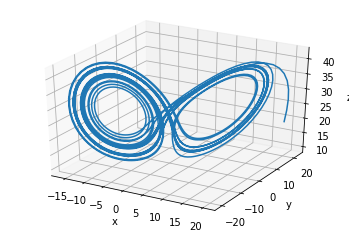

In [304]:
res = solve_ivp(lorenz, (0, T), x0, t_eval=t)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot3D(res.y[0], res.y[1], zs=res.y[2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

## 1.1 Trajectory prediction  

### Dataset Generation

In [305]:
seed(42)

x_train = []
y_train = []
x_test = []
y_test = []
for _ in track(range(100)):
    for r in [10, 28, 40]:
        x0 = 30*(rand(3)-0.5)
        lorenz = lambda t, x: [sig*(x[1] - x[0]), r*x[0] - x[0]*x[2] - x[1], x[0]*x[1] - b*x[2]]
        res = solve_ivp(lorenz, (0, T), x0, t_eval=t)
        #print(res.y[:, :-1].T.shape, array([r]*len(t-1)).reshape(-1, 1).shape)
        #break
        x_train.append(concatenate((res.y[:, :-1].T, array([r]*(len(t)-1)).reshape(-1, 1)), axis=1))
        y_train.append(res.y[:, 1:].T)
        

x_train = concatenate(x_train).astype(float32)
y_train = concatenate(y_train).astype(float32)

for _ in track(range(20)):
    for r in [10, 28, 40]:
        x0 = 30*(rand(3)-0.5)
        lorenz = lambda t, x: [sig*(x[1] - x[0]), r*x[0] - x[0]*x[2] - x[1], x[0]*x[1] - b*x[2]]
        res = solve_ivp(lorenz, (0, T), x0, t_eval=t)
        x_test.append(concatenate((res.y[:, :-1].T, array([r]*(len(t)-1)).reshape(-1, 1)), axis=1))
        y_test.append(res.y[:, 1:].T)

x_test = concatenate(x_test).astype(float32)
y_test = concatenate(y_test).astype(float32)

 [████████████████████████████████████████████████████████████] 100/100 [00:17<00:00, 0.17s/it]

 [████████████████████████████████████████████████████████████] 20/20 [00:03<00:00, 0.16s/it]

In [341]:
model = Sequential([
    Dense(50, input_shape=(4,)),
    Activation('relu'),
    Dense(50),
    Activation('relu'),
    Dense(30),
    Activation('relu'),
    Dense(3),
    Activation('linear')
])

model.compile(optimizer='nadam',
              loss='mse')
model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test))

Train on 599700 samples, validate on 119940 samples
Epoch 1/10
599700/599700 [==============================] - 55s 92us/step - loss: 0.3624 - val_loss: 0.3118
Epoch 2/10
599700/599700 [==============================] - 55s 92us/step - loss: 0.0176 - val_loss: 0.0151
Epoch 3/10
599700/599700 [==============================] - 44s 74us/step - loss: 0.0134 - val_loss: 0.0069
Epoch 4/10
599700/599700 [==============================] - 50s 83us/step - loss: 0.0113 - val_loss: 0.0072
Epoch 5/10
599700/599700 [==============================] - 72s 119us/step - loss: 0.0103 - val_loss: 0.0257
Epoch 6/10
599700/599700 [==============================] - 65s 108us/step - loss: 0.0096 - val_loss: 0.0203
Epoch 7/10
599700/599700 [==============================] - 49s 82us/step - loss: 0.0091 - val_loss: 0.0112
Epoch 8/10
599700/599700 [==============================] - 48s 81us/step - loss: 0.0084 - val_loss: 0.0159
Epoch 9/10
599700/599700 [==============================] - 55s 92us/step - loss: 

In [339]:
x_train_2step = np.concatenate((x_train[:-1, :-1], x_train[1:, :]), axis=1)
y_train_2step = y_train[1:, :]
x_test_2step = np.concatenate((x_test[:-1, :-1], x_test[1:, :]), axis=1)
y_test_2step = y_test[1:, :]

model_2step = Sequential([
    Dense(36, input_shape=(7,)),
    Activation('relu'),
    Dense(36),
    Activation('relu'),
    Dense(36),
    Activation('linear'),
    Dense(3),
    Activation('linear')
])

model_2step.compile(optimizer='nadam',
              loss='mse')

model_2step.fit(x_train_2step, y_train_2step, batch_size=32, validation_data=(x_test_2step, y_test_2step), epochs=10)

Train on 599699 samples, validate on 119939 samples
Epoch 1/10
599699/599699 [==============================] - 47s 78us/step - loss: 0.2029 - val_loss: 0.0251
Epoch 2/10
599699/599699 [==============================] - 53s 88us/step - loss: 0.0262 - val_loss: 0.0209
Epoch 3/10
599699/599699 [==============================] - 72s 121us/step - loss: 0.0198 - val_loss: 0.0410
Epoch 4/10
599699/599699 [==============================] - 51s 85us/step - loss: 0.0158 - val_loss: 0.0082
Epoch 5/10
599699/599699 [==============================] - 51s 84us/step - loss: 0.0131 - val_loss: 0.0094
Epoch 6/10
599699/599699 [==============================] - 49s 82us/step - loss: 0.0114 - val_loss: 0.0109
Epoch 7/10
599699/599699 [==============================] - 46s 77us/step - loss: 0.0102 - val_loss: 0.0045
Epoch 8/10
599699/599699 [==============================] - 48s 79us/step - loss: 0.0094 - val_loss: 0.0042
Epoch 9/10
599699/599699 [==============================] - 52s 88us/step - loss: 0

In [354]:
def predict_lorenz_trajectory_1step(x0, r, steps):
    y_pred = [concatenate((x0, array([r])))]
    x_cur = y_pred[-1]
    for _ in range(steps):
        y_cur = concatenate((model.predict(array([x_cur]))[0], array([r])))
        y_pred.append(y_cur)
        x_cur = y_cur
    return array(y_pred)

In [355]:
def predict_lorenz_trajectory_2step(x0, x1, r, steps):
    y_pred = [x0, x1]
    x_cur = concatenate((x0, x1, array([r]))) 
    for _ in range(steps):
        y_cur = concatenate((x_cur[3:6], model_2step.predict(array([x_cur]))[0], array([r])))
        y_pred.append(y_cur[3:6])
        x_cur = y_cur
    return array(y_pred)

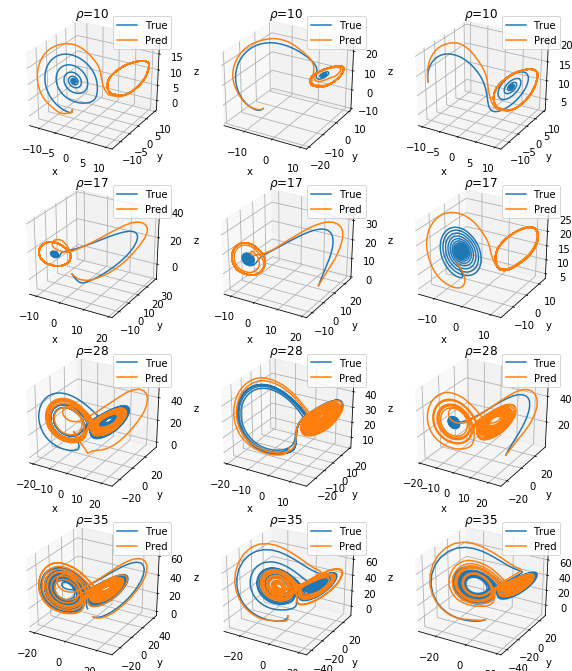

In [376]:
seed(33)

fig = figure(figsize=(10, 12))
grid = plt.GridSpec(4, 3, wspace=0.15, hspace=0.15)

for i in range(3):
    for j, r in enumerate([10, 17, 28, 35]):
        subfig = fig.add_subplot(grid[j, i], projection='3d')

        x0 = 30*(rand(3)-0.5)
        lorenz = lambda t, x: [sig*(x[1] - x[0]), r*x[0] - x[0]*x[2] - x[1], x[0]*x[1] - b*x[2]]
        res = solve_ivp(lorenz, (0, T), x0, t_eval=t)

        y_true = res.y
        # Two-step method
        #x1 = predict_lorenz_trajectory_1step(x0, r, 1)[-1][:-1]
        # One-step method
        #y_pred = predict_lorenz_trajectory_2step(x0, x1, r, y_true.shape[1]).T
        y_pred = predict_lorenz_trajectory_1step(x0, r, y_true.shape[1]).T
        subfig.plot3D(y_true[0], y_true[1], zs=y_true[2], label = "True")
        subfig.plot3D(y_pred[0], y_pred[1], zs=y_pred[2], label = "Pred")
        subfig.legend()
        subfig.set_xlabel('x')
        subfig.set_ylabel('y')
        subfig.set_zlabel('z')
        subfig.set_title(r"$\rho$=%d"%r)

## 1.2 Lobe transition prediction 

In [ ]:
rand_seed = 42
seed(rand_seed)
r=28
lorenz = lambda t, x: [sig*(x[1] - x[0]), r*x[0] - x[0]*x[2] - x[1], x[0]*x[1] - b*x[2]]

x_train_lobes = []
t_train_lobes = []
y_train_lobes = []
x_test_lobes = []
t_test_lobes = []
y_test_lobes = []
for _ in track(range(100000)):
    x0 = 50*(rand(3)-0.5)
    res = solve_ivp(lorenz, (0, T), x0, t_eval=t)
    ans = 0
    t_cross = -1
    for j, (x_prev, x_next) in enumerate(zip(res.y[0][:-1], res.y[0][1:])):
        if x_prev*x_next < 0:
            ans = 1
            t_cross = j
            break
    
    t_train_lobes.append(t_cross)
    x_train_lobes.append(x0)
    y_train_lobes.append(ans)        

x_train_lobes = array(x_train_lobes).astype(float32)
y_train_lobes = array(y_train_lobes).astype(float32)
t_train_lobes = array(t_train_lobes)

for _ in track(range(20000)):
    x0 = 30*(rand(3)-0.5)
    res = solve_ivp(lorenz, (0, T), x0, t_eval=t)
    ans = 0
    t_cross = -1
    for j, (x_prev, x_next) in enumerate(zip(res.y[0][:-1], res.y[0][1:])):
        if x_prev*x_next < 0:
            ans = 1
            t_cross = j
            break
        
    t_test_lobes.append(t_cross)
    x_test_lobes.append(x0)
    y_test_lobes.append(ans)        

x_test_lobes = array(x_test_lobes).astype(float32)
y_test_lobes = array(y_test_lobes).astype(float32)
t_test_lobes = array(t_test_lobes).astype(float32)

100%|██████████| 20000/20000 [18:08<00:00, 18.37it/s]


7.608143

In [ ]:
# lobes_data = {
#     "x_train_lobes": x_train_lobes,
#     "y_train_lobes": y_train_lobes,
#     "t_train_lobes": t_train_lobes,
#     "x_test_lobes": x_test_lobes,
#     "y_test_lobes": y_test_lobes,
#     "t_test_lobes": t_test_lobes,
#     "random_seed": rand_seed
# }
# pickle.dump(lobes_data, open("lobes_data.dump", 'wb'))

In [396]:
lobes_data = pickle.load(open("lobes_data.dump", 'rb'))
x_train_lobes = lobes_data["x_train_lobes"]
y_train_lobes = lobes_data["y_train_lobes"]
t_train_lobes = array(lobes_data["t_train_lobes"])
x_test_lobes = lobes_data["x_test_lobes"]
y_test_lobes = lobes_data["y_test_lobes"]
t_test_lobes = array(lobes_data["t_test_lobes"])

In [398]:
lobes_clf_results = []

for t_stop in track(range(50, 200, 5)):
    y_train_lobes = (t_train_lobes <= t_stop).astype(int)
    y_test_lobes = (t_test_lobes <= t_stop).astype(int)
    
    model = Sequential([
        Dense(30, input_shape=(3,)),
        Activation('sigmoid'),
        Dense(30),
        Activation('sigmoid'),
        Dense(30),
        Activation('sigmoid'),
        Dense(1),
        Activation('sigmoid')
    ])

    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    model.fit(x_train_lobes, y_train_lobes, batch_size=32, epochs=10, verbose=0)
    y_pred_lobes = model.predict(x_test_lobes) > 0.5
    res = {
        "accuracy": accuracy_score(y_test_lobes, y_pred_lobes),
        "f1": f1_score(y_test_lobes, y_pred_lobes),
        "roc_auc": roc_auc_score(y_test_lobes, y_pred_lobes)
    }
    lobes_clf_results.append(res)
    #print("Test loss: %.4f, test accuracy: %.2f"%tuple(model.evaluate(x_test_lobes, y_test_lobes)))

 [████████████████████████████████████████████████████████████] 30/30 [50:04<01:53, 100.14s/it]

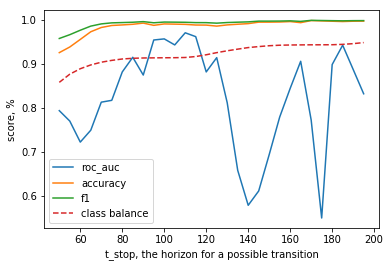

In [413]:
xt = range(50, 200, 5)
plot(xt, [a["roc_auc"] for a in lobes_clf_results], label="roc_auc")
plot(xt, [a["accuracy"] for a in lobes_clf_results], label="accuracy")
plot(xt, [a["f1"] for a in lobes_clf_results], label="f1")
plot(xt, [mean(t_train_lobes <= t_stop) for t_stop in xt], '--', label="class balance")
xlabel("t_stop, the horizon for a possible transition")
ylabel("score, %")
legend()

# 2. Kuramoto-Sivashinsky equation

## Sample initial conditions

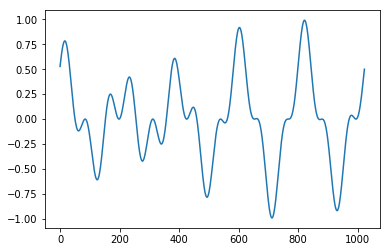

In [283]:
N = 1024;
x = 32*np.pi*np.arange(1,N+1)/N;
alpha, beta, gamma = randint(1, 10, 3) -0.5
u = gamma*np.cos(2*alpha*x/16)*(1+np.sin(2*beta*x/16));
plot(u)
show()

## Data Generation

In [284]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
import matplotlib.pyplot as plt

# Kuramoto-Sivashinsky equation (from Trefethen)
# u_t = -u*u_x - u_xx - u_xxxx,  periodic BCs 
seed(42)

x_train_kse = []
p_train_kse = []
y_train_kse = []
x_test_kse = []
p_test_kse = []
y_test_kse = []

for num in track(range(1000)):
    N = 128;
    x = 32*np.pi*np.arange(1,N+1)/N;
    #alpha, beta, p1, p2 = randint(1, 5, 4)
    alpha, beta, gamma = randint(1, 10, 3) -0.5
    u = gamma*np.cos(2*alpha*x/16)*(1+np.sin(2*beta*x/16));
    v = np.fft.fft(u);

    #Spatial grid and initial condition:
    h = 0.025;
    k = np.concatenate([np.arange(0,N/2),[0],np.arange(-N/2+1,0)])/16;
    L = k**2 - k**4;
    E = np.exp(h*L); E2 = np.exp(h*L/2);
    M = 16;
    r = np.exp(1j*np.pi*(np.arange(1,M+1)-.5)/M)
    LR = h*np.tile(L,(M,1)).T + np.tile(r,(N,1))
    Q = h*np.real(np.mean( (np.exp(LR/2)-1)/LR, axis=1)); 
    f1 = h*np.real(np.mean( (-4-LR+np.exp(LR)*(4-3*LR+LR**2))/LR**3, axis=1)); 
    f2 = h*np.real(np.mean( (2+LR+np.exp(LR)*(-2+LR))/LR**3, axis=1));
    f3 = h*np.real(np.mean( (-4-3*LR-LR**2+np.exp(LR)*(4-LR))/LR**3, axis=1));

    # Main time-stepping loop:
    uu = u; tt = 0;
    tmax = 200; nmax = round(tmax/h); nplt = np.floor((tmax/1000)/h); g = -0.5j*k;
    for n in range(1,nmax+1):
        t = n*h;
        Nv = g*np.fft.fft(np.real(np.fft.ifft(v))**2);
        a = E2*v + Q*Nv;
        Na = g*np.fft.fft(np.real(np.fft.ifft(a))**2);
        b = E2*v + Q*Na;
        Nb = g*np.fft.fft(np.real(np.fft.ifft(b))**2);
        c = E2*a + Q*(2*Nb-Nv);
        Nc = g*np.fft.fft(np.real(np.fft.ifft(c))**2);
        v = E*v + Nv*f1 + 2*(Na+Nb)*f2 + Nc*f3; 
        if np.mod(n,nplt)==0:
            u = np.real(np.fft.ifft(v));
            uu = np.vstack([uu,u]); tt = np.append(tt,t);
    
    n = len(uu)
    train_len_kse = int(n*0.8)

    for u, u_next in zip(uu[:train_len_kse-1, :], uu[1:train_len_kse, :]):
        x_train_kse.append(u)
        y_train_kse.append(u_next)
        p_train_kse.append([alpha, beta, gamma])

    for u, u_next in zip(uu[train_len_kse:-1, :], uu[1+train_len_kse:, :]):
        x_test_kse.append(u)
        y_test_kse.append(u_next)
        p_test_kse.append([alpha, beta, gamma])
    #print(num)
        
x_train_kse = expand_dims(x_train_kse, axis=2).astype(float32)
y_train_kse = array(y_train_kse).astype(float32)
p_train_kse = array(p_train_kse).astype(float32)
x_test_kse = expand_dims(x_test_kse, axis=2).astype(float32)
y_test_kse = array(y_test_kse).astype(float32)
p_test_kse = array(p_test_kse).astype(float32)

kse_data = {
    "x_train": x_train_kse,
    "y_train": y_train_kse,
    "p_train": p_train_kse,
    "x_test": x_test_kse,
    "y_test": y_test_kse,
    "p_test": p_test_kse
}

pickle.dump(kse_data, open('kse_data.dump', 'wb'))
# # Plot results:
# plt.figure(figsize=(5, 15))
# plt.pcolormesh(uu)
# plt.show()

100%|██████████| 1000/1000 [39:17<00:00,  2.36s/it]


## Deep CNN with Multiple Inputs

In [410]:
p_train_kse

array([[6.5, 3.5, 7.5],
       [6.5, 3.5, 7.5],
       [6.5, 3.5, 7.5],
       ...,
       [2.5, 0.5, 5.5],
       [2.5, 0.5, 5.5],
       [2.5, 0.5, 5.5]], dtype=float32)

In [409]:
print(model_kse.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 128, 1)       0                                            
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 126, 4)       16          input_11[0][0]                   
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 3)            0                                            
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 504)          0           conv1d_3[0][0]                   
__________________________________________________________________________________________________
dense_222 

In [405]:
seed(42)
inp1 = Input(shape=(x_train_kse.shape[1], 1))
conv = Conv1D(filters=4, kernel_size=3)(inp1)
#pool = MaxPool1D(pool_size=4)(conv)
flat = Flatten()(conv)
#dense0 = Dense(128)(flat)
inp2 = Input(shape=(3,))
dense_p1 = Dense(3, activation='tanh')(inp2)
merged = Concatenate()([flat, dense_p1])
dense1 = Dense(256, activation='tanh')(merged)
dense2 = Dense(128)(dense1)
model_kse = Model([inp1, inp2], dense2)
model_kse.compile(loss='mse', optimizer='nadam')
print(model_kse.summary())

model_kse.fit([x_train_kse, p_train_kse], y_train_kse, batch_size=32, epochs=10, verbose=1, validation_data=([x_test_kse, p_test_kse], y_test_kse))
model_kse.save("kse_model_%s.dump"%datetime.now())
#print("Test loss: %.4f"%model.evaluate(x_test_kse, y_test_kse))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_218 (Dense)            (None, 30)                120       
_________________________________________________________________
activation_193 (Activation)  (None, 30)                0         
_________________________________________________________________
dense_219 (Dense)            (None, 30)                930       
_________________________________________________________________
activation_194 (Activation)  (None, 30)                0         
_________________________________________________________________
dense_220 (Dense)            (None, 30)                930       
_________________________________________________________________
activation_195 (Activation)  (None, 30)                0         
_________________________________________________________________
dense_221 (Dense)            (None, 1)                 31        
__________

## Testing

In [406]:
def make_kse(rand_seed = 42):
    """Generates random kse solution according to the random seed provided"""
    seed(rand_seed)
    N = 128;
    x = 32*np.pi*np.arange(1,N+1)/N;
    #alpha, beta, p1, p2 = randint(1, 5, 4)
    alpha, beta, gamma = randint(1, 10, 3) -0.5
    u = gamma*np.cos(2*alpha*x/16)*(1+np.sin(2*beta*x/16));
    v = np.fft.fft(u);

    #Spatial grid and initial condition:
    h = 0.025;
    k = np.concatenate([np.arange(0,N/2),[0],np.arange(-N/2+1,0)])/16;
    L = k**2 - k**4;
    E = np.exp(h*L); E2 = np.exp(h*L/2);
    M = 16;
    r = np.exp(1j*np.pi*(np.arange(1,M+1)-.5)/M)
    LR = h*np.tile(L,(M,1)).T + np.tile(r,(N,1))
    Q = h*np.real(np.mean( (np.exp(LR/2)-1)/LR, axis=1)); 
    f1 = h*np.real(np.mean( (-4-LR+np.exp(LR)*(4-3*LR+LR**2))/LR**3, axis=1)); 
    f2 = h*np.real(np.mean( (2+LR+np.exp(LR)*(-2+LR))/LR**3, axis=1));
    f3 = h*np.real(np.mean( (-4-3*LR-LR**2+np.exp(LR)*(4-LR))/LR**3, axis=1));

    # Main time-stepping loop:
    uu = u; tt = 0;
    tmax = 200; nmax = round(tmax/h); nplt = np.floor((tmax/1000)/h); g = -0.5j*k;
    for n in range(1,nmax+1):
        t = n*h;
        Nv = g*np.fft.fft(np.real(np.fft.ifft(v))**2);
        a = E2*v + Q*Nv;
        Na = g*np.fft.fft(np.real(np.fft.ifft(a))**2);
        b = E2*v + Q*Na;
        Nb = g*np.fft.fft(np.real(np.fft.ifft(b))**2);
        c = E2*a + Q*(2*Nb-Nv);
        Nc = g*np.fft.fft(np.real(np.fft.ifft(c))**2);
        v = E*v + Nv*f1 + 2*(Na+Nb)*f2 + Nc*f3; 
        if np.mod(n,nplt)==0:
            u = np.real(np.fft.ifft(v));
            uu = np.vstack([uu,u]); tt = np.append(tt,t);
    return uu, array([alpha, beta, gamma])

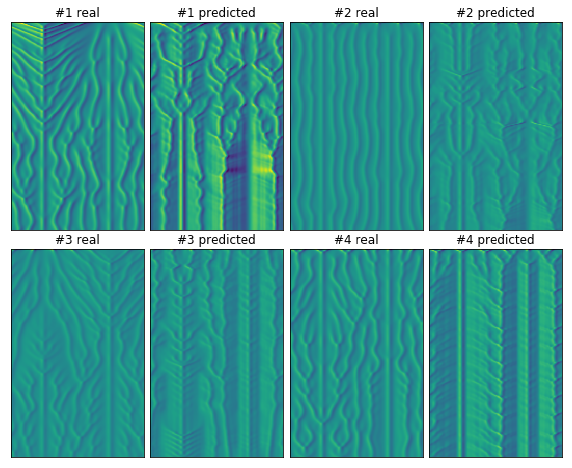

In [418]:
fig = figure(figsize=(10, 8))
grid = plt.GridSpec(4, 4, wspace=0, hspace=0.2)

for i, rs in enumerate([41, 42, 45, 46]):
    test_data, test_p = make_kse(rand_seed=rs)
    test_data = expand_dims(test_data, axis=2).astype(float32)
    pred_data = copy(test_data)
    u = test_data[0, :, :]
    for j in range(1, len(test_data)):
        u_next = model_kse.predict([expand_dims(u, axis=0), expand_dims(test_p, axis=0)]).T
        pred_data[j, :] = u_next
        u = u_next  
    xp = 2*(i//2); yp = 2*(i%2)
    img_real = fig.add_subplot(grid[xp:xp+2, yp])
    img_pred = fig.add_subplot(grid[xp:xp+2, yp+1])
    
    img_real.imshow(test_data[:, :, 0], aspect=0.2)
    img_real.set_title("#%d real"%(i+1))
    img_real.set_xticks([])
    img_real.set_yticks([])
 
    img_pred.imshow(pred_data[:, :, 0], aspect=0.2)
    img_pred.set_title("#%d predicted"%(i+1))
    img_pred.set_xticks([])
    img_pred.set_yticks([])

# 3. Reaction-diffusion equation

In [232]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt

def reaction_diffusion_rhs(t,uvt,K22,d1,d2,beta,n,N):
    # Calculate u and v terms
    ut=np.reshape(uvt[:N],(n,n));
    vt=np.reshape(uvt[N:],(n,n));
    u=np.real(np.fft.ifft2(ut)); v=np.real(np.fft.ifft2(vt));
    
    # Reaction Terms
    u3=u**3; v3=v**3; u2v=(u**2)*v; uv2=u*(v**2);
    utrhs=np.reshape(np.fft.fft2(u-u3-uv2+beta*u2v+beta*v3),(N,1));
    vtrhs=np.reshape(np.fft.fft2(v-u2v-v3-beta*u3-beta*uv2),(N,1));
    
    return np.concatenate([-d1*K22*uvt[:N]+utrhs, -d2*K22*uvt[N:]+vtrhs])[:,0]

# lambda-omega reaction-diffusion system
#  u_t = lam(A) u - ome(A) v + d1*(u_xx + u_yy) = 0
#  v_t = ome(A) u + lam(A) v + d2*(v_xx + v_yy) = 0
#
#  A^2 = u^2 + v^2 and
#  lam(A) = 1 - A^2
#  ome(A) = -beta*A^2

L=50; n=32; N=n*n;
t=np.linspace(0,L,2**13);
d1=0.1; d2=0.1; beta=1.0;
x2=np.linspace(-L/2,L/2,n+1); x=x2[0:n]; y=x;
kx=(2*np.pi/L)*np.concatenate([np.arange(0,n/2), np.arange(-n/2,0)]); ky=kx;

# INITIAL CONDITIONS

[X,Y]=np.meshgrid(x,y);
[KX,KY]=np.meshgrid(kx,ky);
K2=KX**2+KY**2; K22=np.reshape(K2,(N,1));

m=1; # number of spirals

u = np.zeros((len(x),len(y),len(t)));
v = np.zeros((len(x),len(y),len(t)));

u[:,:,0]=np.tanh(np.sqrt(X**2+Y**2))*np.cos(m*np.angle(X+1j*Y)-(np.sqrt(X**2+Y**2)));
v[:,:,0]=np.tanh(np.sqrt(X**2+Y**2))*np.sin(m*np.angle(X+1j*Y)-(np.sqrt(X**2+Y**2)));

# REACTION-DIFFUSION
uvt=np.concatenate([np.reshape(np.fft.fft2(u[:,:,0]).T,(N,1)), np.reshape(np.fft.fft2(v[:,:,0]).T,(N,1))]);
#uvsol=integrate.complex_ode(reaction_diffusion_rhs,uvt[:,0],t,args=(K22,d1,d2,beta,n,N));
sol=integrate.solve_ivp(lambda t,u: reaction_diffusion_rhs(t,u,K22,d1,d2,beta,n,N),[0,L],uvt[:,0],t_eval=t,method='RK45');
uvsol = sol.y

#%%
for j in range(len(t)-1):
    ut=np.reshape(uvsol[:N,j+1],(n,n));
    vt=np.reshape(uvsol[N:,j+1],(n,n));
    u[:,:,j+1]=np.real(np.fft.ifft2(ut));
    v[:,:,j+1]=np.real(np.fft.ifft2(vt));

np.savez('reaction_diffusion_big.npz',t=t,x=x,y=y,u=u,v=v)

# for j in np.arange(20,0,1):
#     plt.figure()
#     plt.pcolormesh(v[:,:,j])
#     plt.axis('image')

## Spectral Analysis of Data

Text(0, 0.5, '$\\lambda_p$, ')

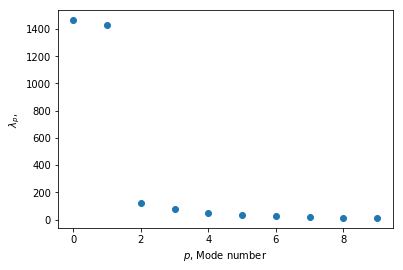

In [236]:
X = v.reshape((32*32, v.shape[2]))
U, S, V = svd(X)
scatter(range(len(S[:10])), S[:10])
xlabel(r"$p$, Mode number")
ylabel(r"$\lambda_p$, ")

In [399]:
rank_trunc = 4
U.shape, S.shape, V.shape
Ur = U[:, :rank_trunc]
test_img = v[:, :, 3]
pcolormesh(test_img)
show()
trunc_test_img = Ur.dot(Ur.T.dot(v[:, :, 3].reshape(32*32))).reshape((32,32))
pcolormesh(trunc_test_img)

IndexError: too many indices for array

## Data Generation and Model Definition

In [238]:
data_rd = (Ur.T.dot(X)).T
m, n = data_rd.shape
x_train_rd = data_rd[:int(m*0.8) - 1, :]
y_train_rd = data_rd[1:int(m*0.8), :]
x_test_rd = data_rd[int(m*0.8):-1, :]
y_test_rd = data_rd[int(m*0.8)+1:, :]
orig_test_rd = v[:, :, int(m*0.8)+1:]

In [241]:
inp = Input((rank_trunc, ))
dense1 = Dense(20, activation='tanh')(inp)
dense2 = Dense(20, activation='tanh')(dense1)
dense3 = Dense(20, activation='tanh')(dense2)
out = Dense(rank_trunc, activation='linear')(dense3)
model_rd = Model(inp, out)
model_rd.compile(loss='mse', optimizer='rmsprop')
print(model_rd.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_19 (Dense)             (None, 20)                100       
_________________________________________________________________
dense_20 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_21 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_22 (Dense)             (None, 4)                 84        
Total params: 1,024
Trainable params: 1,024
Non-trainable params: 0
_________________________________________________________________
None


In [242]:
model_rd.fit(x_train_rd, y_train_rd, batch_size=32, epochs=40, verbose=1, validation_data=(x_test_rd, y_test_rd))

Train on 6552 samples, validate on 1638 samples
Epoch 1/40
6552/6552 [==============================] - 1s 83us/step - loss: 79.2397 - val_loss: 57.5427
Epoch 2/40
6552/6552 [==============================] - 0s 52us/step - loss: 45.3090 - val_loss: 34.7755
Epoch 3/40
6552/6552 [==============================] - 0s 52us/step - loss: 26.1298 - val_loss: 18.9398
Epoch 4/40
6552/6552 [==============================] - 0s 54us/step - loss: 13.0221 - val_loss: 8.7634
Epoch 5/40
6552/6552 [==============================] - 0s 52us/step - loss: 5.0710 - val_loss: 3.2858
Epoch 6/40
6552/6552 [==============================] - 0s 53us/step - loss: 1.4615 - val_loss: 1.5303
Epoch 7/40
6552/6552 [==============================] - 0s 54us/step - loss: 0.6482 - val_loss: 1.3611
Epoch 8/40
6552/6552 [==============================] - 0s 52us/step - loss: 0.5525 - val_loss: 1.2922
Epoch 9/40
6552/6552 [==============================] - 0s 52us/step - loss: 0.5401 - val_loss: 1.2541
Epoch 10/40
6552/6

## Testing 

In [243]:
pred_test_rd = zeros(y_test_rd.shape)
cur = x_test_rd[0, :]
for i in range(pred_test_rd.shape[0] - 1):
    nex = model_rd.predict(cur.reshape(1, -1))
    pred_test_rd[i, :] = nex
    cur = nex
    
X_pred_test_rd = Ur.dot(pred_test_rd.T).reshape((32, 32, 1638))

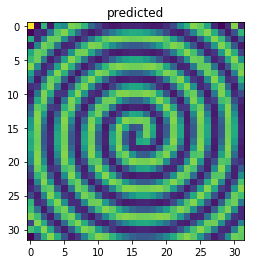

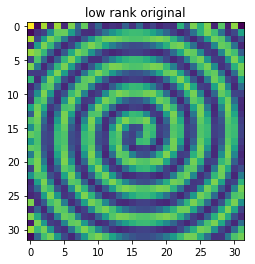

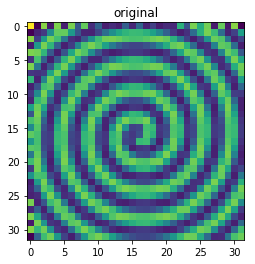

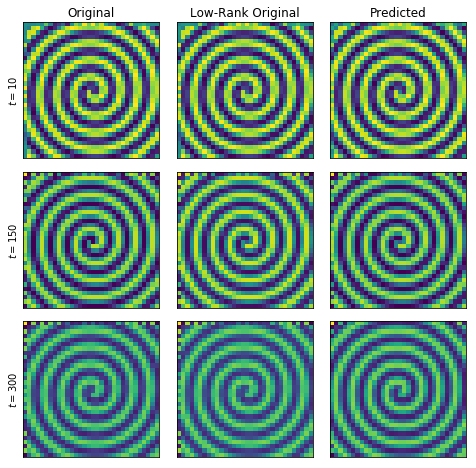

In [282]:
fig = figure(figsize=(8, 8))
grid = plt.GridSpec(3, 3, wspace=0.1, hspace=0.1)
for i, tk in enumerate([10, 150, 300]):
    orig_fig = fig.add_subplot(grid[i, 0])
    orig_fig.imshow(orig_test_rd[:, :, tk])
    orig_fig.set_xticks([])
    orig_fig.set_yticks([])
    low_rank_fig = fig.add_subplot(grid[i, 1])
    low_rank_fig.imshow(Ur.dot(y_test_rd[tk, :].T).reshape((32, 32)))
    low_rank_fig.set_xticks([])
    low_rank_fig.set_yticks([])
    pred_fig = fig.add_subplot(grid[i, 2])
    pred_fig.imshow(X_pred_test_rd[:, :, tk])
    pred_fig.set_xticks([])
    pred_fig.set_yticks([])
    orig_fig.set_ylabel(r"$t = %d$"%tk)
    
    if i == 0:
        orig_fig.set_title("Original")
        low_rank_fig.set_title("Low-Rank Original")
        pred_fig.set_title("Predicted")
        
        